### Group Project 4 : Comparing 3 Models for Predicting Recidivism

For background on this project, please see the [README](../README.md).

**Notebooks**
- [Data Acquisition & Cleaning](./01_data_acq_clean.ipynb)
- [Exploratory Data Analysis](./02_eda.ipynb)
- Modeling (this notebook)
- [Results and Recommendations](./04_results.ipynb)

**In this notebook, you'll find:**
- Classification models for each of the 3 datasets
- TODO etc.

In [1]:
# Imports

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, BaggingClassifier 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

**Model 1: Base feature set - New York**

**Model 2: Criminal history feature set - Florida**

**Model 3: Behavioral feature set - Georgia**

In [2]:
# Reading in the cleaned Georgia data file

ga = pd.read_csv('../data/GA/georgia_cleaned.csv')
ga.drop(columns='Unnamed: 0', inplace=True)
ga.head()

,gender_male,age_at_release,gang_affiliated,supervision_risk_score_first,education_level,dependents,prison_years,prior_arrest_episodes_felony,prior_arrest_episodes_misd,prior_arrest_episodes_violent,...,delinquency_reports,program_attendances,residence_changes,avg_days_per_drugtest,drugtests_thc_positive,drugtests_cocaine_positive,drugtests_meth_positive,drugtests_other_positive,percent_days_employed,recidivism_within_3years
0,1,43-47,0,3.0,at least some college,3,more than 3 years,6,6,1,...,0,6,2,612.000000,0.000000,0.0,0.000000,0.0,0.488562,0
1,1,33-37,0,6.0,less than hs diploma,1,more than 3 years,7,6,3,...,4,0,2,35.666667,0.000000,0.0,0.000000,0.0,0.425234,1
2,1,48 or older,0,7.0,at least some college,3,1-2 years,6,6,3,...,4,6,0,93.666667,0.333333,0.0,0.166667,0.0,0.000000,1
3,1,38-42,0,7.0,less than hs diploma,1,1-2 years,8,6,0,...,0,6,3,25.400000,0.000000,0.0,0.000000,0.0,1.000000,0
4,1,33-37,0,4.0,less than hs diploma,3,1-2 years,4,4,3,...,0,7,0,23.117647,0.000000,0.0,0.058824,0.0,0.203562,1


---

## Dummifying Categorical Columns

In [3]:
cat_cols = ga.select_dtypes(include='object').columns

ga_dummy = pd.get_dummies(ga, columns=cat_cols)
print(ga_dummy.shape)
ga_dummy.head()

(24426, 43)


,gender_male,gang_affiliated,supervision_risk_score_first,dependents,prior_arrest_episodes_felony,prior_arrest_episodes_misd,prior_arrest_episodes_violent,prior_arrest_episodes_property,prior_arrest_episodes_drug,prior_arrest_episodes_ppviolationcharges,...,age_at_release_38-42,age_at_release_43-47,age_at_release_48 or older,education_level_at least some college,education_level_high school diploma,education_level_less than hs diploma,prison_years_1-2 years,prison_years_greater than 2 to 3 years,prison_years_less than 1 year,prison_years_more than 3 years
0,1,0,3.0,3,6,6,1,3,3,4,...,0,1,0,1,0,0,0,0,0,1
1,1,0,6.0,1,7,6,3,0,3,5,...,0,0,0,0,0,1,0,0,0,1
2,1,0,7.0,3,6,6,3,2,2,5,...,0,0,1,1,0,0,1,0,0,0
3,1,0,7.0,1,8,6,0,3,3,3,...,1,0,0,0,0,1,1,0,0,0
4,1,0,4.0,3,4,4,3,2,1,3,...,0,0,0,0,0,1,1,0,0,0


--- 

## Establishing the Baseline

In [4]:
X = ga.drop(columns='recidivism_within_3years')
y = ga['recidivism_within_3years']

y.value_counts(normalize=True)

1    0.596496
0    0.403504
Name: recidivism_within_3years, dtype: float64

This baseline is telling us that if we predicted that all observations in this list would recidivate, we could reasonably expect be correct 59.65% of the time.

Depending on the usage of our model, the metrics we want to optimize for are overall accuracy and specificity. 

---

## Building a Function to Expedite Model Trials

In [5]:
model_trials_df = pd.DataFrame(columns=['model_used', 'train_score', 'test_score',
'accuracy', 'specificity', 'precision', 'recall', 'f1 score', 'true_neg', 'false_pos', 'false_neg', 'true_pos'])

In [6]:
def model_trials(model, model_id):

    '''Setting X and y, and fitting the model'''
    X = ga_dummy.drop(columns='recidivism_within_3years')
    y = ga_dummy['recidivism_within_3years']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42, stratify=y)
    model.fit(X_train, y_train)
    train_score = model.score(X_train, y_train)
    test_score = model.score(X_test, y_test)

    '''Baseline calculation for reference in the returned confusion matrix'''
    baseline = y.value_counts(normalize=True)[1]

    '''Calculating classification rates'''
    preds = model.predict(X_test)
    tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()
    acc = (tp + tn) / (tn + fp + tp + fn)
    spec = tn / (tn + fp)
    prec = tp / (tp + fp)
    recall = tp / (tp + fn)
    f1 = ((prec * recall) / (prec + recall)) * 2

    '''Adding all values to the model_trials dataframe'''
    model_list = [model_id, train_score, test_score, acc, spec, prec, recall, f1, tn, fp, fn, tp]
    model_trials_df.loc[len(model_trials_df.index)] = model_list

    '''Output will show scores and classification metrics'''
    print(model_id)
    print(f'Training Score: {round(train_score, 4)}')
    print(f'Testing Score: {round(test_score, 4)} \n')
    print(f'Accuracy: {round(acc, 4)}')
    print(f'Specificity: {round(spec, 4)}')
    print(f'Precision: {round(prec, 4)}')
    print(f'Recall: {round(recall, 4)}')
    print(f'F1 Score: {round(f1, 4)} \n')

    '''Returning a confusion matrix colored based on performance against the baseline'''
    print('Best accuracy rate confusion matrix:')
    if acc > baseline:
        return ConfusionMatrixDisplay.from_estimator(model, X_test, y_test, cmap='viridis', values_format='d');
    else: 
        return ConfusionMatrixDisplay.from_estimator(model, X_test, y_test, cmap='magma', values_format='d');

---
## Logistic Regression

Logistic Regression
Training Score: 0.7097
Testing Score: 0.6965 

Accuracy: 0.6965
Specificity: 0.5218
Precision: 0.7157
Recall: 0.8147
F1 Score: 0.762 

Best accuracy rate confusion matrix:


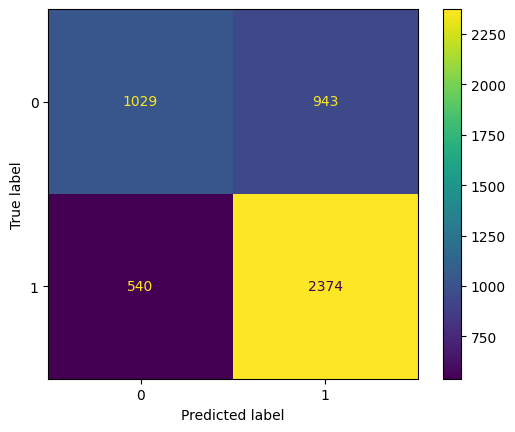

In [7]:
log_reg = LogisticRegression(solver='saga', max_iter = 5000)

model_trials(log_reg, 'Logistic Regression')

### Analysis
This model performed better than the baseline by about 10%, but is struggling with correctly predicting the non-recidivist observations (0 class). This may be a result of the data, or could have to do with the distribution of the data (slight lean towards recidivism = True). 

If we see similar misclassifications in some or most of the subsequent models, it may be necessary to rebalance the data via undersampling or resampling with synthetic data points.

--- 

## Multinomial Naive Bayes

Multinomial Naive Bayes
Training Score: 0.6118
Testing Score: 0.6081 

Accuracy: 0.6081
Specificity: 0.4255
Precision: 0.653
Recall: 0.7316
F1 Score: 0.6901 

Best accuracy rate confusion matrix:


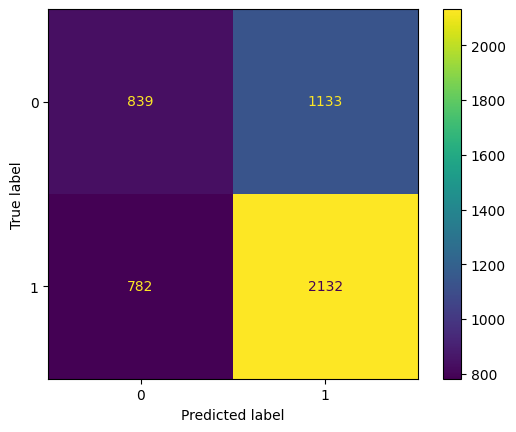

In [8]:
mnb = MultinomialNB()

model_trials(mnb, 'Multinomial Naive Bayes')

### Analysis
This MNB model performed surprisingly poorly and had significantly more false positives and false negatives relative to the Logistic Regression model. 

One possible explanation is that NB classifiers operate on the principle that the presence of one feature does not affect the presence of another. This assumption is not true of this dataset - many features are highly correlated and the presence of 'age_at_release_33-37', for example, would directly result in the absence of a true value in the 'age_at_release_48 or older' column. 

In this case, the model is running on an assumption that is categorically false and would likely run into issues, even in a binary classification model. 

---

## KNN Classifier

KNN
Training Score: 0.7695
Testing Score: 0.6502 

Accuracy: 0.6502
Specificity: 0.5345
Precision: 0.6981
Recall: 0.7286
F1 Score: 0.713 

Best accuracy rate confusion matrix:


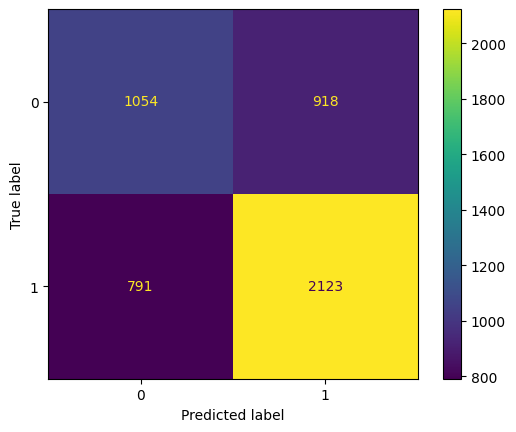

In [9]:
knn = Pipeline([
    ('ss', StandardScaler()),
    ('knn', KNeighborsClassifier())
])

model_trials(knn, 'KNN')

### Analysis
Despite the higher scores, the KNN model saw a handful more false negatives compared to the MNB model above. That being said, both models scored not much higher than the baseline and will likely not be used in the model tuning portion. 

Because KNN performs well with a low number of features, it's probable that the 42 features included in the dummy dataframe are creating too much noise for this model to read through. This, in addition to the fact that KNN uses the mode of the closest observations in a classification model (and our data is not evenly balanced) are two feasible explanations of the low scores seen here.

---

## Decision Tree Classifier

Decision Tree
Training Score: 1.0
Testing Score: 0.623 

Accuracy: 0.623
Specificity: 0.5538
Precision: 0.6893
Recall: 0.6699
F1 Score: 0.6794 

Best accuracy rate confusion matrix:


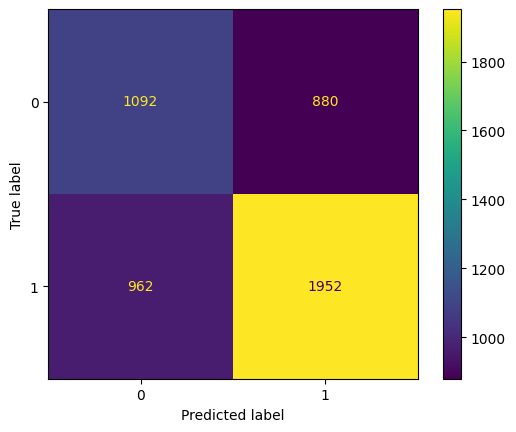

In [10]:
dtree = DecisionTreeClassifier(random_state=42)

model_trials(dtree, 'Decision Tree')

### Analysis


---

## Random Forest Classifier

Random Forest
Training Score: 1.0
Testing Score: 0.7063 

Accuracy: 0.7063
Specificity: 0.5517
Precision: 0.7277
Recall: 0.8109
F1 Score: 0.7671 

Best accuracy rate confusion matrix:


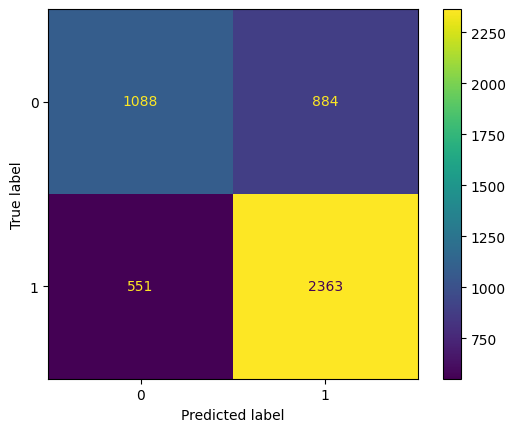

In [11]:
rf = RandomForestClassifier(random_state=42)

model_trials(rf, 'Random Forest')

### Analysis


---

## Bagging Classifier

Bagging
Training Score: 0.986
Testing Score: 0.6682 

Accuracy: 0.6682
Specificity: 0.6045
Precision: 0.7266
Recall: 0.7114
F1 Score: 0.7189 

Best accuracy rate confusion matrix:


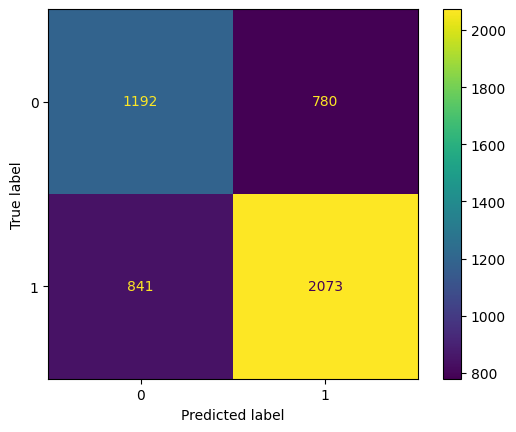

In [12]:
bag = BaggingClassifier(random_state=42)

model_trials(bag, 'Bagging')

### Analysis


--- 

## Ada Boost Classifier

AdaBoost
Training Score: 0.7216
Testing Score: 0.7045 

Accuracy: 0.7045
Specificity: 0.5715
Precision: 0.7326
Recall: 0.7944
F1 Score: 0.7623 

Best accuracy rate confusion matrix:


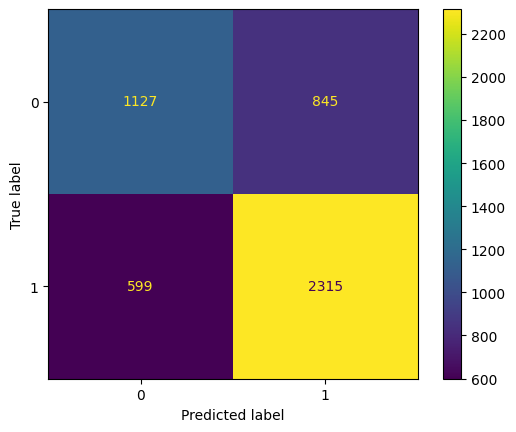

In [13]:
ada = AdaBoostClassifier(random_state=42)

model_trials(ada, 'AdaBoost')

### Analysis


---

## Ada Boost Classifier with Logistic Regression

AdaBoost w/ LogReg
Training Score: 0.7216
Testing Score: 0.7045 

Accuracy: 0.7045
Specificity: 0.5715
Precision: 0.7326
Recall: 0.7944
F1 Score: 0.7623 

Best accuracy rate confusion matrix:


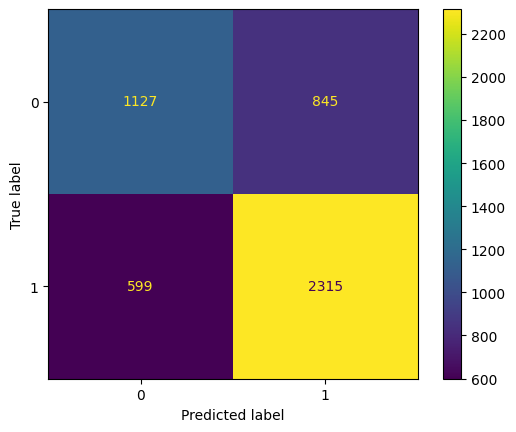

In [14]:
ada_lr = AdaBoostClassifier(base_estimator=LogisticRegression(), random_state=42)

model_trials(ada, 'AdaBoost w/ LogReg')

### Analysis


---

## Gradient Boosting Classifier

Gradient Boosting
Training Score: 0.739
Testing Score: 0.7147 

Accuracy: 0.7147
Specificity: 0.5674
Precision: 0.7356
Recall: 0.8143
F1 Score: 0.773 

Best accuracy rate confusion matrix:


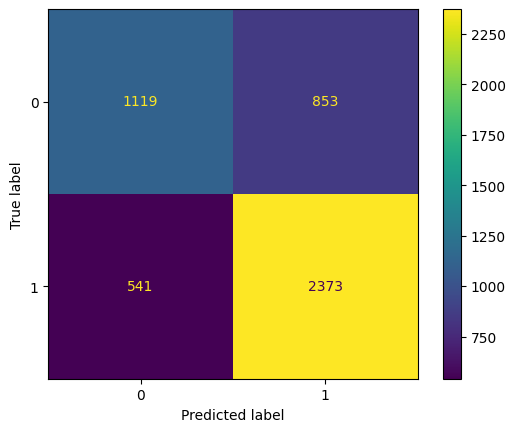

In [15]:
gboost = GradientBoostingClassifier(random_state=42)

model_trials(gboost, 'Gradient Boosting')

### Analysis


---
## Model Evaluation

In [16]:
model_trials_df

,model_used,train_score,test_score,accuracy,specificity,precision,recall,f1 score,true_neg,false_pos,false_neg,true_pos
0,Logistic Regression,0.709672,0.696480,0.696480,0.521805,0.715707,0.814688,0.761996,1029,943,540,2374
1,Multinomial Naive Bayes,0.611771,0.608064,0.608064,0.425456,0.652986,0.731640,0.690079,839,1133,782,2132
2,KNN,0.769550,0.650225,0.650225,0.534483,0.698126,0.728552,0.713014,1054,918,791,2123
3,Decision Tree,1.000000,0.623005,0.623005,0.553753,0.689266,0.669870,0.679429,1092,880,962,1952
4,Random Forest,1.000000,0.706304,0.706304,0.551724,0.727749,0.810913,0.767083,1088,884,551,2363
5,Bagging,0.986029,0.668236,0.668236,0.604462,0.726604,0.711393,0.718918,1192,780,841,2073
6,AdaBoost,0.721648,0.704462,0.704462,0.571501,0.732595,0.794441,0.762265,1127,845,599,2315
7,AdaBoost w/ LogReg,0.721648,0.704462,0.704462,0.571501,0.732595,0.794441,0.762265,1127,845,599,2315
8,Gradient Boosting,0.739048,0.714695,0.714695,0.567444,0.735586,0.814345,0.772964,1119,853,541,2373


** Rewrite, add points

- Multinomial Naive Bayes had lowest accuracy and specificity. Appeared to struggle with overpredicting recidivism - only model with greater than 1,000 false positives.
- Gradient Boost had the best overall accuracy, but lost to Bagging on specificity.
- Logistic Regression and Gradient Boost had significantly less false negative predictions than most other models, meaning these two are better at not classifying non-recidivism in true recidivism observations.

---
## Feature Importance

In [17]:
X = ga_dummy.drop(columns='recidivism_within_3years')
y = ga_dummy['recidivism_within_3years']

log_reg = LogisticRegression(solver='saga', max_iter = 5000)

log_reg.fit(X, y)

LogisticRegression(max_iter=5000, solver='saga')

In [18]:
fi = log_reg.coef_[0]
fi_zipped = list(zip(X.columns, fi))

feats = pd.DataFrame(columns=['feature', 'coef'])

for i in list(range(len(fi_zipped))):
    feats.loc[i] = [fi_zipped[i][0], np.exp(fi_zipped[i][1])]

feats.sort_values(by='coef', ascending=False)

,feature,coef
1,gang_affiliated,2.011773
28,age_at_release_18-22,1.485437
29,age_at_release_23-27,1.348287
0,gender_male,1.345021
12,condition_mh_sa,1.287967
23,drugtests_thc_positive,1.259155
16,violations_instruction,1.252139
15,violations_electronicmonitoring,1.182441
21,residence_changes,1.148551
9,prior_arrest_episodes_ppviolationcharges,1.105204


** Rewrite 

### Analysis
- Those who are gang affiliated are twice as likely to recidivate than those who are not.
- Men are 34% more likely to recidivate than women.
- Regarding percent of days employed during parole, x% of observations worked 100% of the days and x% did not work at all. Those who did not work at all were 71% more likely to recidivate than those who worked all days.

---
## Model Tuning

In [19]:
model_trials_df.sort_values(by='accuracy', ascending=False)

,model_used,train_score,test_score,accuracy,specificity,precision,recall,f1 score,true_neg,false_pos,false_neg,true_pos
8,Gradient Boosting,0.739048,0.714695,0.714695,0.567444,0.735586,0.814345,0.772964,1119,853,541,2373
4,Random Forest,1.000000,0.706304,0.706304,0.551724,0.727749,0.810913,0.767083,1088,884,551,2363
6,AdaBoost,0.721648,0.704462,0.704462,0.571501,0.732595,0.794441,0.762265,1127,845,599,2315
7,AdaBoost w/ LogReg,0.721648,0.704462,0.704462,0.571501,0.732595,0.794441,0.762265,1127,845,599,2315
0,Logistic Regression,0.709672,0.696480,0.696480,0.521805,0.715707,0.814688,0.761996,1029,943,540,2374
5,Bagging,0.986029,0.668236,0.668236,0.604462,0.726604,0.711393,0.718918,1192,780,841,2073
2,KNN,0.769550,0.650225,0.650225,0.534483,0.698126,0.728552,0.713014,1054,918,791,2123
3,Decision Tree,1.000000,0.623005,0.623005,0.553753,0.689266,0.669870,0.679429,1092,880,962,1952
1,Multinomial Naive Bayes,0.611771,0.608064,0.608064,0.425456,0.652986,0.731640,0.690079,839,1133,782,2132


---
## Building a Function to GridSearch Models

In [20]:
model_tuning_df = pd.DataFrame(columns=['model_used', 'train_score', 'test_score', 'accuracy', 'specificity', 'precision', 'recall', 'f1 score',
'true_neg', 'false_pos', 'false_neg', 'true_pos', 'best params'])

In [21]:
def model_tuning(model, params, model_id):

    '''Setting X and y, and fitting the model'''
    X = ga_dummy.drop(columns='recidivism_within_3years')
    y = ga_dummy['recidivism_within_3years']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42, stratify=y)

    '''Baseline calculation for reference in the returned confusion matrix'''
    baseline = y.value_counts(normalize=True)[1]

    '''Instantiating GridSearch'''
    gs = GridSearchCV(model, param_grid=params, n_jobs = -1, verbose = 1, cv = 3)
    gs.fit(X_train, y_train)

    '''Model Evaluation Values'''
    train_score = gs.score(X_train, y_train)
    test_score = gs.score(X_test, y_test)
    best_params = gs.best_params_
    best_estimator = gs.best_estimator_

    '''Calculating model classification metrics'''
    preds = gs.predict(X_test)
    tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()
    acc = (tp + tn) / (tn + fp + tp + fn)
    spec = tn / (tn + fp)
    prec = tp / (tp + fp)
    recall = tp / (tp + fn)
    f1 = ((prec * recall) / (prec + recall)) * 2

    '''Adding all values to the model_tuning dataframe'''
    model_list = [model_id, train_score, test_score, acc, spec, prec, recall, f1, tn, fp, fn, tp, best_params]
    model_tuning_df.loc[len(model_tuning_df.index)] = model_list

    '''Output will show best parameters, scores and classification metrics'''
    print(model_id)
    print(f'Best Params: {best_params}')
    print(f'Training Score: {round(train_score, 4)}')
    print(f'Testing Score: {round(test_score, 4)} \n')
    print(f'Accuracy: {round(acc, 4)}')
    print(f'Specificity: {round(spec, 4)}')
    print(f'Precision: {round(prec, 4)}')
    print(f'Recall: {round(recall, 4)}')
    print(f'F1 Score: {round(f1, 4)} \n')
    

    '''Returning a confusion matrix for the best-performing model found during gridsearch'''
    print('Best accuracy rate confusion matrix:')
    if acc > baseline:
        return ConfusionMatrixDisplay.from_estimator(best_estimator, X_test, y_test, cmap='viridis', values_format='d');
    else: 
        return ConfusionMatrixDisplay.from_estimator(best_estimator, X_test, y_test, cmap='magma', values_format='d');

---
## Gradient Boosting Classifier

In [22]:
print('Previous scores:')
model_trials_df[model_trials_df['model_used'] == 'Gradient Boosting']

Previous scores:


,model_used,train_score,test_score,accuracy,specificity,precision,recall,f1 score,true_neg,false_pos,false_neg,true_pos
8,Gradient Boosting,0.739048,0.714695,0.714695,0.567444,0.735586,0.814345,0.772964,1119,853,541,2373


In [23]:
gb = GradientBoostingClassifier(random_state=42)

gb_params  = {
    'n_estimators': [50, 100, 200], 
    'max_depth': [3, 5, 7],
    'learning_rate': [0.7, 0.8, 0.9],
    'max_features': [None, 'sqrt']
}

In [ ]:
model_tuning(gb, gb_params, 'Gradient Boosting')

** Rewrite

### Analysis
- Test score is slightly less than no-param model.
- Decreased false positives, increased false negatives.

---
## Random Forest Classifier

In [24]:
print('Previous scores:')
model_trials_df[model_trials_df['model_used'] == 'Random Forest']

Previous scores:


,model_used,train_score,test_score,accuracy,specificity,precision,recall,f1 score,true_neg,false_pos,false_neg,true_pos
4,Random Forest,1.0,0.706304,0.706304,0.551724,0.727749,0.810913,0.767083,1088,884,551,2363


In [25]:
rf = RandomForestClassifier(random_state=42)

rf_params  = {
    'n_estimators': [50, 100, 150], 
    'max_depth': [3, 5, 7],
    'max_features': [None, 'sqrt'],
    'bootstrap' : [True, False]
}

In [28]:
model_tuning(rf, rf_params, 'Random Forest')

In [ ]:
rf_2 = RandomForestClassifier(random_state=42)

rf_2_params  = {
    'n_estimators': [150, 200, 250], 
    'max_depth': [6, 7, 8],
    'bootstrap' : [True],
    'max_samples': [None, 0.5, 0.8]
}

In [ ]:
model_tuning(rf_2, rf_2_params, 'Random Forest v2')

### Analysis

---
## Ada Boost Classifier

In [ ]:
print('Previous scores:')
model_trials_df[model_trials_df['model_used'] == 'AdaBoost']

In [ ]:
ada = AdaBoostClassifier(random_state=42)

ada_params = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.7, 0.8, 0.9],
}

In [ ]:
model_tuning(ada, ada_params, 'AdaBoost')

In [ ]:
ada_2 = AdaBoostClassifier(random_state=42)

ada_params_2 = {
    'n_estimators': [350, 400, 450],
    'learning_rate': [0.6, 0.7, 0.75],
}

In [ ]:
model_tuning(ada_2, ada_params_2, 'AdaBoost v2')

### Analysis

Because there is a trade-off between n_estimators and learning_rate, I inversely shifted the range of the two hyperparameters, and this specific model seemed to prefer the lower learning rate and higher amount of estimators.

---
## Logistic Regression

In [ ]:
lr = LogisticRegression(random_state=42, max_iter=10_000, solver='saga')

lr_params = {
    'C': [0.1, 1, 10],
    'penalty': ['l1', 'l2'],
    'class_weight': ['balanced', None]
}

In [ ]:
model_tuning(lr, lr_params, 'Logistic Regression')

### Analysis


--- 
## Bagging Classifier

In [ ]:
bag = BaggingClassifier(random_state=42, n_jobs= -1)

bag_params = {
    'max_samples': [0.5, 0.8, 0.9],
    'bootstrap': [True, False],
    'bootstrap_features': [True, False]
}

In [ ]:
model_tuning(bag, bag_params, 'Bagging')

In [ ]:
bag_2 = BaggingClassifier(random_state=42, n_jobs= -1)

bag_2_params = {
    'n_estimators': [100, 200, 300],
    'max_samples': [0.5, 0.6],
    'bootstrap': [True, False],
    'bootstrap_features': [True, False]
}

In [ ]:
model_tuning(bag_2, bag_2_params, 'Bagging v2')

### Analysis


---
## Model Evaluation

In [ ]:
model_tuning_df

In [ ]:
model_tuning_df.describe()

In [ ]:
model_tuning_df[['model_used', 'accuracy', 'specificity']].sort_values(by=['accuracy'], ascending=False)

---
## Conclusion



**Final selected models for each dataset**

**FINAL NOTES**
- The model statistics are exported [here](../data/model_stats.csv).
- The next notebook in the series is [Results and Recommendations](./04_results.ipynb).